### Read data (wav)
First read in high cavitation files.

In [1]:
from pathlib import Path
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [64]:
def read_wav(dataset_names):
    samplerate = []
    df = []
    for data in dataset_names:
        path =  Path.cwd()/"data"
        sf, d = wavfile.read(path/data)
        samplerate.append(sf)
        df.append(d)
    return samplerate , df

In [65]:
datasets = ["s00000_191115_007_KesselpumpHD02_002_RP1_FC_01_P06_SB1_L0_KS_XXXX_YY_YYYY_ZZZZZZ_16.wav"]
#,"sxmany_200206_007_HKMNetzpumpe04_004_RP1_FC_01_C06_SB1_L0_XX_XXXX_YY_YYYY_ZZZZZZ_10.wav"
sr, df = read_wav(datasets)

C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


## Splitting

Splitting the data in 2 second samples

In [4]:

def splitting (sr, df, sec):
    #get sr for section
    seg_len = int(sr * sec)

    splits = []

    for data in df:
        #get number of sections
        sections = int(np.ceil(len(data) / seg_len))
        for i in range(sections):
            #slice section range
            t = data[i * seg_len: (i + 1) * seg_len]
            splits.append(t)


    return splits

In [5]:
df_split = splitting(sr[0],df, 3)

## Fourier Transformation

Transform data into frequency domain.

In [6]:
from scipy.fftpack import fft, ifft

def fourier_trans(sr, data):
    df_ftt = []
    freq = []
    for i in data:

        length = i.shape[0] / sr
        N = i.shape[0]
        n = np.arange(N)
        freq.append(n/length)
        df_ftt.append(fft(i))

    return freq, df_ftt

In [7]:
freq, df_fft = fourier_trans(sr[0],df_split)

In [8]:
def plot_whole_freq(frequency, spectrum):

    plt.figure(figsize = (12, 6))
    plt.subplot(121)

    plt.stem(frequency[1], np.abs(spectrum), 'b', \
             markerfmt=" ", basefmt="-b")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')

    plt.show()

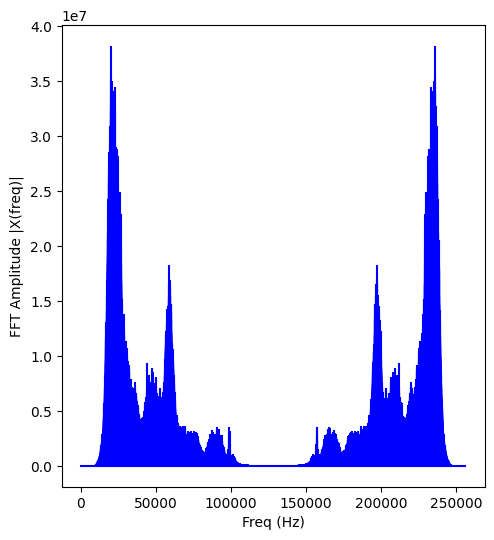

In [9]:
plot_whole_freq(freq,df_fft[0])

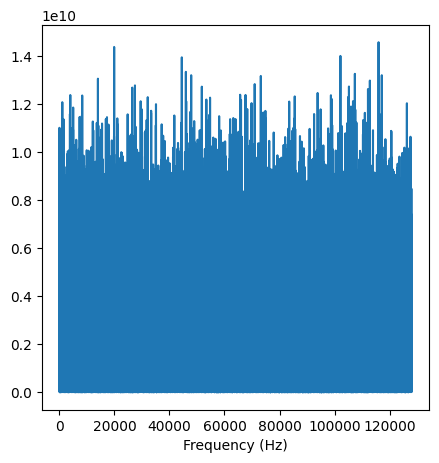

In [10]:
def plot_half_freq(frequency, spectrum):

    X = np.fft.fft(spectrum)
    X_mag = np.abs(X)
    f = np.linspace(0, sr[0], len(X_mag))
    half = int(len(X_mag)/2)
    fft_fre = np.fft.rfftfreq(len(X_mag), d=1./frequency)

    abs_spec = abs(X_mag[:half+1])
    plt.figure(figsize=(5, 5))
    plt.plot(fft_fre, abs_spec) # magnitude spectrum
    plt.xlabel('Frequency (Hz)')
    plt.show()

plot_half_freq(sr[0],df_fft[0])

## Feature extraction and labels

Extract statistical features and add a label.

In [11]:
import os
import scipy.io as scio
from scipy.stats import norm, kurtosis, skew
import pandas as pd
import math
import csv
'''
1. Central Trend Statistics:
   --- mean
   --- median
   --- low quartile
   --- upper quartile
2. Dispersion Degree Statistics:
   --- minimum
   --- maximum
   --- inter quartile range
   --- standard deviation
   --- root mean square
   --- square root amplitude
3. Distribution Shape Statistics
   --- kurtosis
   --- skewness
   --- shape factor
   --- clearance shape
   --- crest factor
'''


def feature_extraction(df, label):
    column_name = ["mean", "median", "quartile_25", "quartile_75", "Max", "Min", "quartile", "std", "rms", "sra", "ff", "clf", "cf"]
    #, "kurtosis", "skew"
    df_features = pd.DataFrame(columns = column_name) #

    for data in df:
        feature_list = []

           # central trend statistics
        data_mean = np.mean(data)
        data_median = np.median(data)
        data_quartile_025 = np.quantile(data, 0.25)
        data_quartile_075 = np.quantile(data, 0.75)

           # dispersion degree statistics
        data_Minimum = np.min(data)
        data_Maximum = np.max(data)
        data_quartile = data_quartile_075 - data_quartile_025
        data_std = np.std(data)
        data_rms = np.sqrt((np.mean(data**2)))
        data_sra = (np.sum(np.sqrt(np.abs(data)))/len(data))**2

           # distribution shape statistics
        #data_kurtosis = kurtosis(data)
        #data_skew = skew(data)

        data_avg = np.mean(np.abs(data))
        data_ff = data_rms / data_avg

        data_clf = np.max(np.abs(data)) / data_sra
        data_cf = np.max(np.abs(data)) / data_rms

        feature_list = [data_mean, data_median, data_quartile_025, data_quartile_075, data_Maximum, data_Minimum, data_quartile, data_std, data_rms, data_sra, data_ff, data_clf, data_cf]
        #, data_kurtosis, data_skew
        feature_list = pd.DataFrame(data=feature_list).T #,
        feature_list.columns = column_name

        df_features = pd.concat([df_features,feature_list])

    if label == "Cavitation":
        df_features["Cavitation"] = 1

    if label == "No Cavitation":
        df_features["Cavitation"] = 0

    if label != "No Cavitation" and label != "Cavitation":
        df_features["Cavitation"] = label
    return df_features











In [13]:
h_c_df = feature_extraction(df_fft, "Cavitation")

In [14]:
h_c_df

,mean,median,quartile_25,quartile_75,Max,Min,quartile,std,rms,sra,ff,clf,cf,Cavitation
0,132.999557-0.001403j,-8402.701172+2022.086426j,-3.316557e+05-7.097342e+05j,324030.585938-92091.468750j,2.959309e+07+1.098878e+07j,-3.184295e+07-4.022216e+05j,6.556863e+05+6.176428e+05j,3.347851e+06+0.000000e+00j,178311.265625+0.003113j,9.835843e+05+0.000000e+00j,0.103426+0.000000j,38.850296+0.000000j,214.302444-0.000004j,1
0,7773.000000+0.000042j,9234.220703+2076.793457j,-3.373612e+05-1.879962e+06j,349140.2734308-5015.0156250j,3.931353e+07+1.065752e+07j,-4.316405e+07-2.777042e+06j,6.865014e+05+1.874947e+06j,3.600573e+06+0.000000e+00j,63768.699219-0.059338j,1.035276e+06+0.000000e+00j,0.035049-0.000000j,41.779479+0.000000j,678.283997+0.000631j,1
0,-3872.999268+0.000179j,-1392.1552703+0.0000000j,-3.580012e+05-3.196015e+05j,359122.953125+64002.375000j,5.253647e+07+2.529366e+07j,-3.942198e+07-9.195399e+05j,7.171242e+05+3.836039e+05j,3.896460e+06+0.000000e+00j,97768.882812+0.017005j,1.071007e+06+0.000000e+00j,0.050679+0.000000j,54.442417+0.000000j,596.388489-0.000104j,1
0,-6543.000000-0.000018j,-7365.1035106+0.0000000j,-3.631528e+05+5.584581e+04j,357423.125000-121367.914062j,3.896221e+07+7.579948e+06j,-4.352423e+07-3.949310e+06j,7.205759e+05-1.772137e+05j,3.881908e+06+0.000000e+00j,0.009449+197390.656250j,1.075551e+06+0.000000e+00j,0.000000+0.102482j,48.104516+0.000000j,0.000013-262.113983j,1
0,3593.999756+0.000669j,6415.8554609+0.0000000j,-3.574148e+05-9.789201e+05j,362113.507812+16311.562500j,4.536585e+07+1.346066e+07j,-4.304962e+07-1.993961e+06j,7.195283e+05+9.952317e+05j,3.853041e+06+0.000000e+00j,0.033212-119697.140625j,1.084553e+06+0.000000e+00j,0.000000-0.062219j,43.631527+0.000000j,0.000110+395.337006j,1
0,-5400.000977-0.000492j,-6235.2343705+0.0000000j,-3.669967e+05-2.734716e+05j,358989.039062+281348.031250j,4.640448e+07+1.731127e+07j,-4.430170e+07-9.937717e+06j,7.259858e+05+5.548196e+05j,3.878200e+06+0.000000e+00j,293643.656250+0.010175j,1.084086e+06+0.000000e+00j,0.151845+0.000000j,45.686723+0.000000j,168.668152-0.000006j,1
0,5450.999023+0.000378j,7383.1171808+0.0000000j,-2.819249e+05-7.612922e+05j,292544.578125+156431.476562j,2.860768e+07+5.291486e+06j,-3.816049e+07-1.154219e+06j,5.744695e+05+9.177236e+05j,3.004322e+06+0.000000e+00j,172298.031250+0.005595j,8.547183e+05+0.000000e+00j,0.113651+0.000000j,44.667279+0.000000j,221.580826-0.000007j,1


## Same procedure for non-cavitation data.

Load file

In [15]:
datasets = ["sxmany_200206_007_HKMNetzpumpe04_004_RP1_FC_01_C06_SB1_L0_XX_XXXX_YY_YYYY_ZZZZZZ_10.wav"]

sr, df = read_wav(datasets)

C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


### Split file

In [16]:
df_split = splitting(sr[0],df, 2)

### Fourier transformation

In [17]:
freq, df_ftt = fourier_trans(sr[0],df_split)

### Feature extraction and add labels

In [18]:
n_c_df = feature_extraction(df_ftt, "No_cavitation")

In [19]:
n_c_df

,mean,median,quartile_25,quartile_75,Max,Min,quartile,std,rms,sra,ff,clf,cf,Cavitation
0,189.000031-0.000026j,285.6171808+0.0000000j,-47249.166992-23157.303711j,47166.263672+38939.902344j,3.911730e+06+3.376144e+05j,-3.661462e+06-9.321004e+05j,94415.4306640+62097.2060550j,488590.65625+0.00000j,0.000303-39125.550781j,173445.881346+0.000000j,0.000000-0.135776j,23.184109+0.000000j,0.000001+102.776527j,No_cavitation
0,338.999939+0.000046j,442.6064405-1.6757810j,-50010.841797-14338.849609j,50798.1943360+9380.1406250j,3.785041e+06+2.757947e+06j,-3.834865e+06-2.318076e+05j,100809.036133+23718.990234j,534752.30075+0.00000j,3735.512939+0.045839j,186286.328881+0.000000j,0.011946+0.000000j,25.140049+0.000000j,1253.709351-0.015384j,No_cavitation
0,130.000046+0.000005j,116.105469-872.466797j,-49651.8085940-6787.7763670j,50475.595703+18213.832031j,3.968321e+06+4.189253e+05j,-4.272759e+06-5.266678e+04j,100127.404297+25001.608398j,5387140000.5+0.00000j,0.005976-8752.074219j,186719.025093+0.000000j,0.000000-0.027893j,23.373341+0.000000j,0.000340+498.652924j,No_cavitation
0,-108.000008-0.000011j,-422.4370005+0.0000000j,-44462.8818306+580.0703120j,44095.830078-252996.437500j,3.280548e+06+1.183303e+06j,-3.466732e+06-7.951549e+05j,88558.711914-253576.507812j,461055.56025+0.00000j,0.003064-15845.906250j,160745.265083+0.000000j,0.000000-0.059037j,26.382631+0.000000j,0.000052+267.632721j,No_cavitation
0,-486.000000-0.000112j,778.2011720+34.4609380j,-56428.169922-23419.488281j,54220.079102+78690.031250j,5.136562e+06+1.732015e+06j,-4.814440e+06-2.671949e+05j,110648.249023+102109.519531j,628457.00075+0.00000j,31533.066406-0.001130j,214693.541053+0.000000j,0.086848-0.000000j,25.248612+0.000000j,171.905701+0.000006j,No_cavitation
0,-243.000092+0.000096j,-893.9062500+66.1416020j,-54796.658203-56730.414062j,55363.051758-47339.570312j,4.646875e+06+1.764615e+06j,-5.107823e+06-2.856950e+05j,110159.7099601+9390.8437500j,577104.80075+0.00000j,77137.242188+0.000657j,205354.467083+0.000000j,0.228135+0.000000j,24.912078+0.000000j,66.3208390-0.0000010j,No_cavitation
0,141.999954-0.000066j,265.414062-6783.554688j,-52241.909180+83787.273438j,51704.750977+21008.066406j,4.342194e+06+4.057747e+05j,-4.544058e+06-2.042053e+04j,103946.660156-62779.207031j,570660.93075+0.00000j,0.003618+19663.138672j,195369.663166+0.000000j,0.000000+0.059276j,23.721198+0.000000j,0.000043-235.689850j,No_cavitation
0,-116.000031+0.000034j,736.7539060-78.3984380j,-53944.679688+177818.156250j,54024.5859380-7816.3984380j,4.522008e+06+4.689853e+05j,-4.376050e+06-1.115578e+06j,107969.265625-185634.554688j,559219.80075+0.00000j,0.003584+14613.500000j,196387.101085+0.000000j,0.000000+0.044580j,23.149494+0.000000j,0.000076-311.100159j,No_cavitation
0,-369.999878+0.000112j,-646.8076107+0.0000000j,-45643.958008-10078.812500j,44771.3173830+8318.4277340j,4.009059e+06+2.567968e+05j,-4.061546e+06-2.280218e+06j,90415.2753910+18397.2402340j,491752.65625+0.00000j,14337.999023+0.000654j,169149.798923+0.000000j,0.050280+0.000000j,28.887049+0.000000j,340.789429-0.000016j,No_cavitation
0,-294.000092-0.000053j,-497.0634770-67.2490230j,-51091.940430-30785.869141j,50301.433594+10756.394531j,4.094237e+06+1.327382e+06j,-4.902808e+06-1.658629e+06j,101393.374023+41542.263672j,546348.43075+0.00000j,0.002014-26406.824219j,190932.976511+0.000000j,0.000000-0.082408j,27.107774+0.000000j,0.000015+196.001144j,No_cavitation


### Combine both datasets

In [20]:
final_df = pd.concat([h_c_df, n_c_df])

In [21]:
final_df

,mean,median,quartile_25,quartile_75,Max,Min,quartile,std,rms,sra,ff,clf,cf,Cavitation
0,132.999557-0.001403j,-8402.701172+2022.086426j,-3.316557e+05-7.097342e+05j,324030.585938-92091.468750j,2.959309e+07+1.098878e+07j,-3.184295e+07-4.022216e+05j,6.556863e+05+6.176428e+05j,3.347851e+06+0.000000e+00j,178311.265625+0.003113j,9.835843e+05+0.000000e+00j,0.103426+0.000000j,38.850296+0.000000j,214.302444-0.000004j,1
0,7773.000000+0.000042j,9234.220703+2076.793457j,-3.373612e+05-1.879962e+06j,349140.2734308-5015.0156250j,3.931353e+07+1.065752e+07j,-4.316405e+07-2.777042e+06j,6.865014e+05+1.874947e+06j,3.600573e+06+0.000000e+00j,63768.699219-0.059338j,1.035276e+06+0.000000e+00j,0.035049-0.000000j,41.779479+0.000000j,678.283997+0.000631j,1
0,-3872.999268+0.000179j,-1392.1552703+0.0000000j,-3.580012e+05-3.196015e+05j,359122.953125+64002.375000j,5.253647e+07+2.529366e+07j,-3.942198e+07-9.195399e+05j,7.171242e+05+3.836039e+05j,3.896460e+06+0.000000e+00j,97768.882812+0.017005j,1.071007e+06+0.000000e+00j,0.050679+0.000000j,54.442417+0.000000j,596.388489-0.000104j,1
0,-6543.000000-0.000018j,-7365.1035106+0.0000000j,-3.631528e+05+5.584581e+04j,357423.125000-121367.914062j,3.896221e+07+7.579948e+06j,-4.352423e+07-3.949310e+06j,7.205759e+05-1.772137e+05j,3.881908e+06+0.000000e+00j,0.009449+197390.656250j,1.075551e+06+0.000000e+00j,0.000000+0.102482j,48.104516+0.000000j,0.000013-262.113983j,1
0,3593.999756+0.000669j,6415.8554609+0.0000000j,-3.574148e+05-9.789201e+05j,362113.507812+16311.562500j,4.536585e+07+1.346066e+07j,-4.304962e+07-1.993961e+06j,7.195283e+05+9.952317e+05j,3.853041e+06+0.000000e+00j,0.033212-119697.140625j,1.084553e+06+0.000000e+00j,0.000000-0.062219j,43.631527+0.000000j,0.000110+395.337006j,1
0,-5400.000977-0.000492j,-6235.2343705+0.0000000j,-3.669967e+05-2.734716e+05j,358989.039062+281348.031250j,4.640448e+07+1.731127e+07j,-4.430170e+07-9.937717e+06j,7.259858e+05+5.548196e+05j,3.878200e+06+0.000000e+00j,293643.656250+0.010175j,1.084086e+06+0.000000e+00j,0.151845+0.000000j,45.686723+0.000000j,168.668152-0.000006j,1
0,5450.999023+0.000378j,7383.1171808+0.0000000j,-2.819249e+05-7.612922e+05j,292544.578125+156431.476562j,2.860768e+07+5.291486e+06j,-3.816049e+07-1.154219e+06j,5.744695e+05+9.177236e+05j,3.004322e+06+0.000000e+00j,172298.031250+0.005595j,8.547183e+05+0.000000e+00j,0.113651+0.000000j,44.667279+0.000000j,221.580826-0.000007j,1
0,189.000031-0.000026j,285.61718008+0.00000000j,-4.724917e+04-2.315730e+04j,47166.2636720+38939.9023440j,3.911730e+06+3.376144e+05j,-3.661462e+06-9.321004e+05j,9.441543e+04+6.209721e+04j,4.885907e+05+0.000000e+00j,0.000303-39125.550781j,1.734459e+05+0.000000e+00j,0.000000-0.135776j,23.184109+0.000000j,0.000001+102.776527j,No_cavitation
0,338.999939+0.000046j,442.60644005-1.67578100j,-5.001084e+04-1.433885e+04j,50798.1943360+9380.1406250j,3.785041e+06+2.757947e+06j,-3.834865e+06-2.318076e+05j,1.008090e+05+2.371899e+04j,5.347524e+05+0.000000e+00j,3735.5129309+0.0458390j,1.862863e+05+0.000000e+00j,0.011946+0.000000j,25.140049+0.000000j,1253.709351-0.015384j,No_cavitation
0,130.000046+0.000005j,116.1054690-872.4667970j,-4.965181e+04-6.787776e+03j,50475.5957030+18213.8320310j,3.968321e+06+4.189253e+05j,-4.272759e+06-5.266678e+04j,1.001274e+05+2.500161e+04j,5.387145e+05+0.000000e+00j,0.005976-80752.0742190j,1.867190e+05+0.000000e+00j,0.000000-0.027893j,23.373341+0.000000j,0.000340+498.652924j,No_cavitation


In [22]:

def feature_pipe (datasets, splits_in_sec, label):
    sr, df = read_wav(datasets)
    df_split = splitting(sr[0],df, splits_in_sec)
    freq, df_ftt = fourier_trans(sr[0],df_split)
    output_df = feature_extraction(df_ftt, label)
    return len(df_split), output_df

In [23]:
No_cav_files = ["sxmany_200206_007_HKMNetzpumpe04_004_RP1_FC_01_C06_SB1_L0_XX_XXXX_YY_YYYY_ZZZZZZ_10.wav"]
cav_files = ["s00000_191115_007_KesselpumpHD02_002_RP1_FC_01_P06_SB1_L0_KS_XXXX_YY_YYYY_ZZZZZZ_16.wav"]


no_cav_df = feature_pipe(No_cav_files,0.1,"No Cavitation")[1]
cav_df = feature_pipe(cav_files,0.1,"Cavitation")[1]
final_df = pd.concat([no_cav_df, cav_df])
final_df.astype('float')

C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


,mean,median,quartile_25,quartile_75,Max,Min,quartile,std,rms,sra,ff,clf,cf,Cavitation
0,188.999985,-346.398438,-10175.405273,9655.065430,636732.250,-5.432184e+05,19830.470703,97756.429688,1998.384766,33490.408257,3.502536e-02,19.181160,321.452057,0.0
0,857.999939,676.756958,-9252.479492,9865.675293,579818.125,-4.631204e+05,19118.154785,93044.656250,11605.215820,32991.720219,2.109103e-01,20.142217,57.261013,0.0
0,-214.999878,-413.046875,-15554.760986,14128.928711,1108530.375,-1.028691e+06,29683.689697,189870.781250,9746.165039,62127.772666,8.944551e-02,22.862561,145.739380,0.0
0,-312.000031,-44.036133,-8508.910645,8332.677002,546172.000,-5.955421e+05,16841.587646,88768.648438,5044.041016,28706.564610,1.010708e-01,22.325745,127.059914,0.0
0,-52.999954,410.257080,-6458.427734,7189.333984,369466.750,-2.471501e+05,13647.761719,44837.882812,6603.390137,17882.190187,2.390725e-01,20.681046,56.004929,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1110.999268,2798.148438,-61784.951172,69072.613281,4297929.000,-3.934186e+06,130857.564453,640163.312500,93960.445312,194297.649250,2.839211e-01,26.679180,55.168980,1.0
0,-3284.000000,-5751.750000,-70404.218750,57803.674805,4430649.000,-5.511242e+06,128207.893555,648224.062500,0.009218,194780.823202,2.783027e-08,28.906868,0.000030,1.0
0,4189.000488,3295.250977,-60473.977539,65948.023438,4125214.000,-4.619242e+06,126422.000977,617776.750000,82554.875000,186831.620213,2.605528e-01,31.661161,71.653023,1.0
0,4286.999512,994.078125,-56394.882812,67361.906250,4518601.000,-4.024674e+06,123756.789062,585920.437500,0.002589,182160.340662,8.334363e-09,26.033057,0.000003,1.0


XGBOOST


In [24]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = final_df["Cavitation"]
X = final_df.loc[:, final_df.columns != 'Cavitation'].astype('float')

X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.3, random_state=1623806)



gbm_param_grid = {
    'clf__learning_rate': np.arange(.05, 1, .05),
    'clf__max_depth': np.arange(3,10, 1),
    'clf__n_estimators': np.arange(50, 200, 50)
}
#model = xgb.XGBClassifier()

model = xgb.XGBClassifier(silent=False,
                      scale_pos_weight=1,
                      learning_rate=0.01,
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic',
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=4,
                      gamma=10)
model.fit(X_train, y_train)
print(model)
predicted_y = model.predict(X_test)

C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


[11:38:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=10, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              

In [25]:
pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
11,clf,0.199951
2,quartile_25,0.132305
4,Max,0.130893
3,quartile_75,0.122323
5,Min,0.121713
7,std,0.110953
6,quartile,0.104797
9,sra,0.077065
0,mean,0.000000
1,median,0.000000


In [55]:
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))
precision,recall,fscore,support=score(y_test,predicted_y,average='macro')
eval= metrics.classification_report(y_test, predicted_y, output_dict=True)
eval['macro avg']['f1-score']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        63

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

[[57  0]
 [ 0 63]]


1.0

In [27]:

def Classification_pipe (splits_in_sec, cavitation_data, no_cavitation_data,test_split_ratio ):

    non_cav_len, no_cav_df = feature_pipe(no_cavitation_data,splits_in_sec,"No Cavitation")
    cav_len, cav_df = feature_pipe(cavitation_data,splits_in_sec,"Cavitation")
    final_df = pd.concat([no_cav_df, cav_df])

    y = final_df["Cavitation"]
    X = final_df.loc[:, final_df.columns != 'Cavitation'].astype('float')


    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = test_split_ratio, random_state = 1623806)

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    print(model)

    predicted_y = model.predict(X_test)
    print(metrics.classification_report(y_test, predicted_y))
    print(metrics.confusion_matrix(y_test, predicted_y))
    return metrics.confusion_matrix(y_test, predicted_y)

In [28]:
No_cav_files = ["sxmany_200206_007_HKMNetzpumpe04_004_RP1_FC_01_C06_SB1_L0_XX_XXXX_YY_YYYY_ZZZZZZ_10.wav"]
cav_files = ["s00000_191115_007_KesselpumpHD02_002_RP1_FC_01_P06_SB1_L0_KS_XXXX_YY_YYYY_ZZZZZZ_16.wav"]

Classification_pipe(1, cav_files, No_cav_files, 0.3)

C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      

C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


array([[4, 0],
       [0, 8]], dtype=int64)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
def Classification_pipe_Grid (splits_in_sec, cavitation_data, no_cavitation_data,test_split_ratio ):
    #read in files
    print(f'\n Reading in files, splitting in {splits_in_sec} second samples, transforming and extracting features')
    non_cav_len, no_cav_df = feature_pipe(no_cavitation_data,splits_in_sec,"No Cavitation")
    cav_len, cav_df = feature_pipe(cavitation_data,splits_in_sec,"Cavitation")
    final_df = pd.concat([no_cav_df, cav_df])
    length = cav_len + non_cav_len
    print(f'\n Done! We have {length} samples!')
    #y = final_df["Cavitation"]
    #X = final_df.loc[:, final_df.columns != 'Cavitation'].astype('float')
    #split in train test, keep for output

    train, test = train_test_split(final_df, test_size = test_split_ratio, random_state = 1623806)
    X_train = train.loc[:, final_df.columns != 'Cavitation'].astype('float')
    X_test = test.loc[:, final_df.columns != 'Cavitation'].astype('float')
    y_train = train["Cavitation"]
    y_test = test["Cavitation"]
    print(f'\n Train set: {len(train)} samples!')
    print(f'\n Test set: {len(test)} samples!')
    print('\n Starting Gridsearch, fine tuning parameters')
    model = xgb.XGBClassifier()
    #parameters for gridsearch
    param = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(100, 1000, 100),
    'learning_rate': [0.1, 0.01, 0.05]
}
    grid = GridSearchCV(model, param, n_jobs=5,
                    cv = 10,
                       #StratifiedKFold( n_splits=5, shuffle=True),
                       scoring='roc_auc', verbose=True, refit=True)

    grid.fit(X_train, y_train)
    #Output
    print('\n Best estimator:')
    print(grid.best_estimator_)
    print('\n  best_score_:')
    print(grid.best_score_)
    print('\n Best parameters:')
    print(grid.best_params_)

    predicted_y = grid.predict(X_test)

    print('\n Classification report on unseen test set:')
    print(metrics.classification_report(y_test, predicted_y))
    print('\n Confusion matrix on unseen test set')
    print(metrics.confusion_matrix(y_test, predicted_y))
    importance = pd.DataFrame({'Variable':X.columns,
              'Importance':grid.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)
    print('\n Feature importance:')
    print(importance)
    return train, test, grid.best_estimator_
   # predicted_y = model.predict(X_test)
   # print(metrics.classification_report(y_test, predicted_y))
   # print(metrics.confusion_matrix(y_test, predicted_y))
   # return metrics.confusion_matrix(y_test, predicted_y)

In [ ]:
train, test, best_model = Classification_pipe_Grid(1, cav_files, No_cav_files, 0.3)

In [ ]:
best_model.predict(X_test)

In [ ]:

metrics.confusion_matrix(y_test, model.predict(X_test))

We only two datasets for each label which may be homogenous, especially the cavitation set.


In [79]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

split_eval_list = np.arange(0.1,1,0.1)
def Classification_pipe_all (splits_in_sec, cavitation_data, no_cavitation_data,test_split_ratio, evaluation = "accuracy" , split_eval: bool = False):
    #read in files
    print(f'\n Reading in files, splitting in {splits_in_sec} second samples, transforming and extracting features')
    param = {
            'max_depth': range (2, 10, 1),
            'n_estimators': range(100, 1000, 100),
            'learning_rate': [0.1, 0.01, 0.05]
        }
    if split_eval == True:
        print(f"splitting evaluation is set to true, range is {splits_in_sec}")

        f1_result = []
        acc_result = []
        sample_size_list = []
        splits_list = []
        for splits in split_eval_list:
            splits_list.append(splits)
            non_cav_len, no_cav_df = feature_pipe(no_cavitation_data,splits,"No Cavitation")
            cav_len, cav_df = feature_pipe(cavitation_data,splits,"Cavitation")
            final_df = pd.concat([no_cav_df, cav_df])
            length = cav_len + non_cav_len
            sample_size_list.append(length)
            print(f"{splits} second splits")
            train, test = train_test_split(final_df, test_size = test_split_ratio, random_state = 1623806)
            X_train = train.loc[:, final_df.columns != 'Cavitation'].astype('float')
            X_test = test.loc[:, final_df.columns != 'Cavitation'].astype('float')
            y_train = train["Cavitation"]
            y_test = test["Cavitation"]

            print(f'\n Train set: {len(train)} samples!,  Test set: {len(test)} samples!')
            model = xgb.XGBClassifier()
            model.fit(X_train, y_train)
            predicted_y = model.predict(X_test)
            eval = metrics.classification_report(y_test, predicted_y, output_dict=True)
            print(f'\n Classification report on unseen test set:')
            print(f"\n accuracy:{eval['accuracy']}, f1: {eval['macro avg']['f1-score']}")
            f1_result.append(eval['macro avg']['f1-score'])
            acc_result.append(eval["accuracy"])
        zipped = list(zip(splits_list, sample_size_list, f1_result, acc_result,  ))
        output = pd.DataFrame(zipped, columns=['Splits_in_sec', 'Sample_size', 'f1', 'accuracy'])



        if evaluation == "f1":
            optim = output.loc[output['f1'].idxmax(), 'Splits_in_sec']
            print(f"\n Evuation method is {evaluation}")
            print(f"\n best split size is {optim} seconds!")
            non_cav_len, no_cav_df = feature_pipe(no_cavitation_data,splits,"No Cavitation")
            cav_len, cav_df = feature_pipe(cavitation_data,splits,"Cavitation")
            final_df = pd.concat([no_cav_df, cav_df])
            train, test = train_test_split(final_df, test_size = test_split_ratio, random_state = 1623806)
            X_train = train.loc[:, final_df.columns != 'Cavitation'].astype('float')
            X_test = test.loc[:, final_df.columns != 'Cavitation'].astype('float')
            y_train = train["Cavitation"]
            y_test = test["Cavitation"]
            print(f'\n Train set: {len(train)} samples!,  Test set: {len(test)} samples!')
            print('\n Fitting best model:')
            model = xgb.XGBClassifier()

            grid = GridSearchCV(model, param, n_jobs=5,
                            cv = 10,
                               #StratifiedKFold( n_splits=5, shuffle=True),
                               scoring='roc_auc', verbose=True, refit=True)

            grid.fit(X_train, y_train)
            #Output
            print('\n Best estimator:')
            print(grid.best_estimator_)
            print('\n Best parameters:')
            print(grid.best_params_)

            predicted_y = grid.predict(X_test)

            eval = metrics.classification_report(y_test, predicted_y, output_dict=True)
            print(f'\n Classification report on unseen test set:')
            print(f"\n accuracy:{eval['accuracy']}, f1: {eval['macro avg']['f1-score']}")
            return train, test, grid.best_estimator_, output

        if evaluation == "accuracy":

            optim = output.loc[output['accuracy'].idxmax(), 'Splits_in_sec']
            print(f"\n Evuation method is {evaluation}")
            print(f"\n best split size is {optim} seconds!")
            non_cav_len, no_cav_df = feature_pipe(no_cavitation_data,splits,"No Cavitation")
            cav_len, cav_df = feature_pipe(cavitation_data,splits,"Cavitation")
            final_df = pd.concat([no_cav_df, cav_df])
            train, test = train_test_split(final_df, test_size = test_split_ratio, random_state = 1623806)
            X_train = train.loc[:, final_df.columns != 'Cavitation'].astype('float')
            X_test = test.loc[:, final_df.columns != 'Cavitation'].astype('float')
            y_train = train["Cavitation"]
            y_test = test["Cavitation"]
            print('\n Fitting best model:')

            print(f'\n Train set: {len(train)} samples!,  Test set: {len(test)} samples!')
            model = xgb.XGBClassifier()

            grid = GridSearchCV(model, param, n_jobs=5,
                            cv = 10,
                               #StratifiedKFold( n_splits=5, shuffle=True),
                               scoring='roc_auc', verbose=True, refit=True)

            grid.fit(X_train, y_train)
            #Output
            print('\n Best estimator:')
            print(grid.best_estimator_)
            print('\n Best parameters:')
            print(grid.best_params_)

            predicted_y = grid.predict(X_test)
            predicted_y = model.predict(X_test)
            eval = metrics.classification_report(y_test, predicted_y, output_dict=True)
            print(f'\n Classification report on unseen test set:')
            print(f"\n accuracy:{eval['accuracy']}, f1: {eval['macro avg']['f1-score']}")
            return train, test, grid.best_estimator_, output




    else:
        if isinstance(split_eval,np.ndarray):
            print("This is of type np.ndarray. Only input one variable when split evaluation is set to false.")
        else:
            non_cav_len, no_cav_df = feature_pipe(no_cavitation_data,splits_in_sec,"No Cavitation")
            cav_len, cav_df = feature_pipe(cavitation_data,splits_in_sec,"Cavitation")
            final_df = pd.concat([no_cav_df, cav_df])
            length = cav_len + non_cav_len
            print(f'\n Done! We have {length} samples!')


            train, test = train_test_split(final_df, test_size = test_split_ratio, random_state = 1623806)
            X_train = train.loc[:, final_df.columns != 'Cavitation'].astype('float')
            X_test = test.loc[:, final_df.columns != 'Cavitation'].astype('float')
            y_train = train["Cavitation"]
            y_test = test["Cavitation"]
            print(f'\n Train set: {len(train)} samples!')
            print(f'\n Test set: {len(test)} samples!')
            print('\n Starting Gridsearch, fine tuning parameters')
            model = xgb.XGBClassifier()
            #parameters for gridsearch

            grid = GridSearchCV(model, param, n_jobs=5,
                            cv = 10,
                               #StratifiedKFold( n_splits=5, shuffle=True),
                               scoring='roc_auc', verbose=True, refit=True)

            grid.fit(X_train, y_train)
            #Output
            print('\n Best estimator:')
            print(grid.best_estimator_)
            print('\n Best parameters:')
            print(grid.best_params_)

            predicted_y = model.predict(X_test)

            print('\n Classification report on unseen test set:')
            print(metrics.classification_report(y_test, predicted_y, output_dict=True))
            print('\n Confusion matrix on unseen test set')
            print(metrics.confusion_matrix(y_test, predicted_y))

            return train, test, grid.best_estimator_
   # predicted_y = model.predict(X_test)
   # print(metrics.classification_report(y_test, predicted_y))
   # print(metrics.confusion_matrix(y_test, predicted_y))
   # return metrics.confusion_matrix(y_test, predicted_y)

In [81]:
train, test, model, eval_df  = Classification_pipe_all (split_eval_list,  cav_files, No_cav_files, 0.3 , evaluation = "f1" , split_eval =True)


 Reading in files, splitting in [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] second samples, transforming and extracting features
splitting evaluation is set to true, range is [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


0.1 second splits

 Train set: 280 samples!,  Test set: 120 samples!

 Classification report on unseen test set:

 accuracy:1.0, f1: 1.0


C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


0.2 second splits

 Train set: 140 samples!,  Test set: 60 samples!

 Classification report on unseen test set:

 accuracy:1.0, f1: 1.0


C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


0.30000000000000004 second splits

 Train set: 93 samples!,  Test set: 41 samples!

 Classification report on unseen test set:

 accuracy:1.0, f1: 1.0


C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


0.4 second splits

 Train set: 70 samples!,  Test set: 30 samples!

 Classification report on unseen test set:

 accuracy:1.0, f1: 1.0


C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


0.5 second splits

 Train set: 56 samples!,  Test set: 24 samples!

 Classification report on unseen test set:

 accuracy:1.0, f1: 1.0


C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


0.6 second splits

 Train set: 47 samples!,  Test set: 21 samples!

 Classification report on unseen test set:

 accuracy:1.0, f1: 1.0


C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


0.7000000000000001 second splits

 Train set: 40 samples!,  Test set: 18 samples!

 Classification report on unseen test set:

 accuracy:1.0, f1: 1.0


C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


0.8 second splits

 Train set: 35 samples!,  Test set: 15 samples!

 Classification report on unseen test set:

 accuracy:1.0, f1: 1.0


C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)


0.9 second splits

 Train set: 32 samples!,  Test set: 14 samples!

 Classification report on unseen test set:

 accuracy:0.9285714285714286, f1: 0.9251336898395721

 Evuation method is f1

 best split size is 0.1 seconds!


C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\AppData\Local\Temp\ipykernel_2044\3207606025.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf, d = wavfile.read(path/data)
C:\Users\kinos\TU_Wien\Interdis_project\Code\venv\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)



 Train set: 32 samples!,  Test set: 14 samples!

 Fitting best model:
Fitting 10 folds for each of 216 candidates, totalling 2160 fits

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

 Best parameters:
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}

 Classification report on unseen test set:

 accuracy:0.9285714285714286, f

In [82]:
eval_df

,Splits_in_sec,Sample_size,f1,accuracy
0,0.1,400,1.000000,1.000000
1,0.2,200,1.000000,1.000000
2,0.3,134,1.000000,1.000000
3,0.4,100,1.000000,1.000000
4,0.5,80,1.000000,1.000000
5,0.6,68,1.000000,1.000000
6,0.7,58,1.000000,1.000000
7,0.8,50,1.000000,1.000000
8,0.9,46,0.925134,0.928571
